# HowTo: Model fluctuating head boundaries with `ttim`

This notebook shows how fluctuating head boundaries, such as a head with a varying river, can be modeled with `ttim`. The example is for a cross-sectional model, but the same holds for a two-dimensional model. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import ttim

Define parameters for a single unconfined aquifer. The head in the river fluctuates as a cosine with period $\tau$. 

In [2]:
# parameters
k = 20.0  # hydraulic conductivity, m/d
H = 50.0  # thickness of aquifer, m
T = k * H  # transmissivity, m^2/d
S = 0.1  # storage coefficient, -
tau = 0.5  # tidal period, d

The analytic solution for the head is given by the following function (see Bakker and Post, 2020).

In [3]:
# solution for unit amplitude
def head_river(t, tau, tp=0):
    return np.cos(2 * np.pi * (t - tp) / tau)


def analytic_head(x, t, tau, S, T, tp=0):
    B = np.exp(-x * np.sqrt(S * np.pi / (T * tau)))
    ts = x * np.sqrt(S * tau / (4 * np.pi * T))
    return B * np.cos(2 * np.pi * (t - tp - ts) / tau)

The analytic solution is for a river with varying head that has been varying for ever. 
In `ttim`, head is simulated for several days to get the model to spin-up. 
In interpreting the results, we only look at the heads in the final tidal period.

In `ttim`, the specified head in a river is constant for a period. For example, `tsandh=[(0, 1), (1, 2), (4, -2)]` means the head in the river equal to 1 from $t=0$ till $t=1$, equal to 2 from $t=1$ till $t=4$ and equal to -2 thereafter. The head in a river fluctuates continuously, of course, and will be approximated by a step function. 

Consider the case that the head is specified using regular time intervals $\Delta t$ (this is not necessary of course, but practical for most applications). 
There are three different ways to specify a continuously vary head boundary in `ttim`. 

- The head at time $t$ is used for the interval from $t$ till $t+\Delta t$. This is referred to as *begin*.
- The head at time $t+\Delta t$ is used for the interval from $t$ till $t+\Delta t$. This is referred to as *end*.
- The average between the heads at $t$ and $t+\Delta t$ is used for the interval from $t$ till $t+\Delta t$. This is referred to as *mid*.

A graph for these three options is shown below.

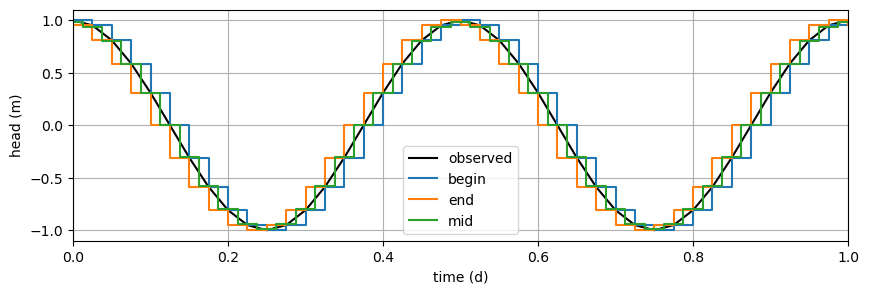

In [4]:
tmax = 5  # day
delt = 0.025  # day
t = np.arange(0, tmax, delt)
hexact = head_river(t, tau)
hbegin = head_river(t, tau)
hend = head_river(t + delt, tau)
hmid = 0.5 * (head_river(t - delt / 2, tau) + head_river(t + delt / 2, tau))
tmid = np.hstack((0, 0.5 * (t[:-1] + t[1:])))
# plot
plt.figure(figsize=(10, 3))
plt.plot(t, hexact, "k", label="observed")
plt.step(t, hbegin, where="post", label="begin")
plt.step(t, hend, where="post", label="end")
plt.step(tmid, hmid, where="post", label="mid")
plt.xlim(0, 1)
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.legend()
plt.grid()

A model is created for all three options.

In [5]:
mlbegin = ttim.ModelXsection(naq=1, tmin=1e-4, tmax=1e2)
xsection = ttim.XsectionMaq(
    model=mlbegin, x1=-np.inf, x2=np.inf, kaq=k, z=[0, -H], Saq=S, phreatictop=True
)
lsriver = ttim.HeadLineSink1D(
    model=mlbegin, xls=0, tsandh=list(zip(t, hbegin, strict=True))
)
mlbegin.solve(silent=True)
#
mlmid = ttim.ModelXsection(naq=1, tmin=1e-4, tmax=1e2)
xsection = ttim.XsectionMaq(
    model=mlmid, x1=-np.inf, x2=np.inf, kaq=k, z=[0, -H], Saq=S, phreatictop=True
)
lsriver = ttim.HeadLineSink1D(
    model=mlmid, xls=0, tsandh=list(zip(tmid, hmid, strict=True))
)
mlmid.solve(silent=True)
#
mlend = ttim.ModelXsection(naq=1, tmin=1e-4, tmax=1e2)
xsection = ttim.XsectionMaq(
    model=mlend, x1=-np.inf, x2=np.inf, kaq=k, z=[0, -H], Saq=S, phreatictop=True
)
lsriver = ttim.HeadLineSink1D(model=mlend, xls=0, tsandh=list(zip(t, hend, strict=True)))
mlend.solve(silent=True)

Let's compare the output for all three options. First we look at the head along
$x$ at 4 moments in the tidal period. As we can see the *mid* option best
matches the analytical solution. The `ttim` and exact solutions are closer
together when the interval $\Delta t$ is reduced.

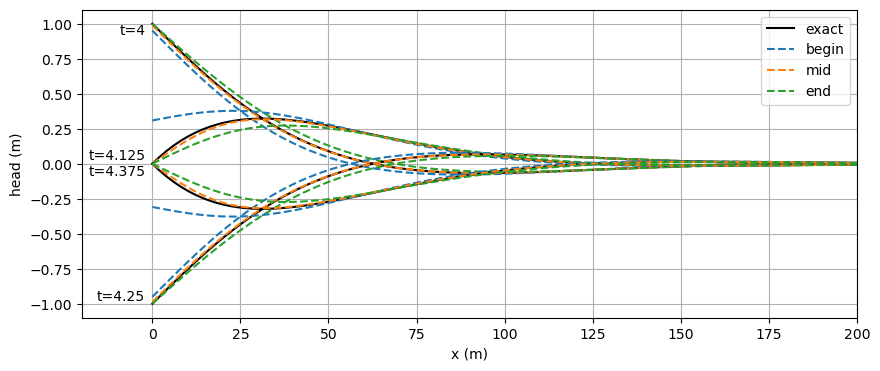

In [6]:
x = np.linspace(0, 200, 100)
tlist = [4, 4.125, 4.25, 4.375]
plt.figure(figsize=(10, 4))
for tp in tlist:
    hex = analytic_head(x, tp, tau, S, T)
    plt.plot(x, hex, "k")
    for i, ml in enumerate([mlbegin, mlmid, mlend]):
        h = ml.headalongline(x, 0, tp)
        plt.plot(x, h[0, 0], "C" + str(i), linestyle="--")
plt.text(-2, 1, "t=4", ha="right", va="top")
plt.text(-2, 0.01, "t=4.125", ha="right", va="bottom")
plt.text(-2, -0.01, "t=4.375", ha="right", va="top")
plt.text(-2, -1, "t=4.25", ha="right", va="bottom")
plt.xlim(-20, 200)
plt.legend(["exact", "begin", "mid", "end"])
plt.xlabel("x (m)")
plt.ylabel("head (m)")
plt.grid()

Next we compare the head at $x=50$ m for the last tidal period. Here we can
clearly see that the *begin* and *end* result in solutions that trail and lead
the analytic solution, respectively. The *mid* option matches nicely with the
analytical solution.

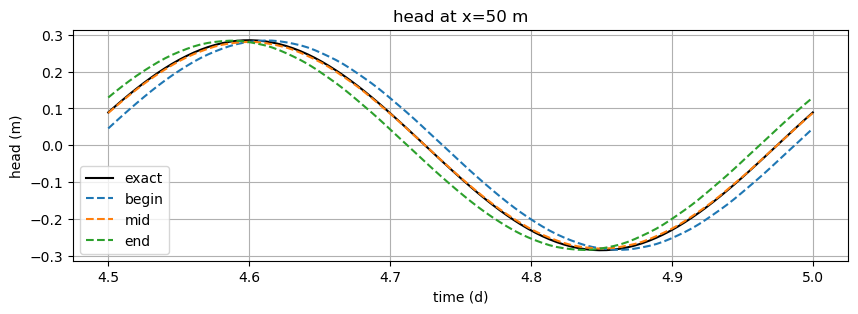

In [7]:
plt.figure(figsize=(10, 3))
tp = np.linspace(4.5, 5, 100)
hex = analytic_head(50, tp, tau, S, T)
plt.plot(tp, hex, "k")
for ml in [mlbegin, mlmid, mlend]:
    h = ml.head(50, 0, tp)
    plt.plot(tp, h[0], "--")
plt.legend(["exact", "begin", "mid", "end"])
plt.xlabel("time (d)")
plt.ylabel("head (m)")
plt.title("head at x=50 m")
plt.grid()

In conclusion, when modeling fluctuating boundary conditions in `ttim`, use the *mid* approximation as the input time series for your model.